In [1]:
import networkx as nx
import random
import numpy as np
import subprocess
import pandas as pd
import os
import matplotlib.pyplot as plt
import shutil
import csv
from collections import defaultdict

import sys
sys.path.append("SDTED/")

from SDTED_utilities import *
from main import SDTED

# Results

In [ ]:
# We Load DARPA E3 GRAPHS

array_graphs_DARPA = []
for root, dirs, files in os.walk("graphs/DARPA_E3/", topdown=False):
   for index, name in enumerate(files):
      if name.endswith(".gml"):
        G = nx.read_gml(os.path.join(root, name))
        array_graphs_DARPA.append(G)

MUTATIONS_CALCULATE = [1,2,3,4,5,6,7,8,9,10]
NUM_GRAPHS = 100
arr_mutations = [delete_random_node, delete_random_edge, change_direction_edge, add_random_node, add_random_edge]

arr_graphs = []
for index, graph in enumerate(array_graphs_DARPA[:]):
    print("Processing graph number", index + 1)
    arr_mut_metrics = []
    G_base = graph.copy()
    for num_mutations in MUTATIONS_CALCULATE:
        arr_g_candidate = []
        arr_precs = []
        arr_recalls = []
        arr_f1s = []

        arr_g_candidate.append(G_base)
        for graph in range(NUM_GRAPHS):
            G_candidate = G_base.copy()
            G_muted, log_mutations = mute_graph(G_candidate, arr_mutations, num_mutations)
            folder_path = "graphs/" + NAME_DS + '/' + str(num_mutations) + '/'
            if not os.path.exists(folder_path):
                os.makedirs(folder_path)
            nx.write_gexf(G_muted, folder_path + 'G_' + str(graph + 1) + ".gexf")
            with open(folder_path + 'G_' + str(graph + 1) + ".log", 'w') as f: 
                for string in log_mutations:
                    f.write(string + '\n') 
            arr_precs.append(calc_precision(G_base, G_muted))
            arr_recalls.append(calc_recall(G_base, G_muted))
            arr_f1s.append(calc_f1_score(G_base, G_muted))
            arr_g_candidate.append(G_muted)

        arr_g_candidate.append(nx.DiGraph())

        write_SDTED_graphs(arr_g_candidate)
        SDTED("SDTED/Data/CUSTOM")

        df = pd.read_csv("Distance_Matrix.csv", nrows=1)
        shutil.copy2("Distance_Matrix.csv", "graphs/" + NAME_DS + '/' + str(num_mutations) + '/' + 'distance_matrix_'+ str(NUM_GRAPHS) + '.csv')  

        arr_SDTED = df.values.tolist()[0][1:]  # [0] gets the first (and only) row
        arr_SDTED = [1 - min(x / arr_SDTED[-1], 1) for x in arr_SDTED][1:][:-1]
        arr_metrics = [arr_precs, arr_recalls, arr_f1s, arr_SDTED]

        num_filas = max(len(arr) for arr in arr_metrics)

        trasp_metrics = []
        for i in range(num_filas):
            fila = [arr[i] if i < len(arr) else "" for arr in arr_metrics]
            trasp_metrics.append(fila)

        with open("graphs/" + NAME_DS + '/' + str(num_mutations) + '/metrics_' + str(NUM_GRAPHS) + '.csv' , "w", newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Precision", "Recall", "F1-score", "SDTED"])
            for array in trasp_metrics:
                writer.writerow(array)

        arr_mut_metrics.append(arr_metrics)
    arr_graphs.append(arr_mut_metrics)

In [ ]:
METRICS_NAME  = ["Precision", "Recall", "F1-score", "SDTED"]
arr_set_all_merged = {}
for mut in MUTATIONS_CALCULATE:
    arr_set_all_merged[mut] = [set() for _ in METRICS_NAME]
dict_num_values = {}
for index, graph in enumerate(arr_graphs[:]):
    dict_num_values[index] = {}
    for index_mut, number_mut in enumerate(graph):
        array_set_mutations = []
        dict_num_values[index][MUTATIONS_CALCULATE[index_mut]] = {}
        for index_j, metric in enumerate(number_mut):
            set_mut_metric =  set()
            for value in metric:
                set_mut_metric.add(value)
                arr_set_all_merged[MUTATIONS_CALCULATE[index_mut]][index_j].add(value)
            array_set_mutations.append(set_mut_metric)
            dict_num_values[index][MUTATIONS_CALCULATE[index_mut]][METRICS_NAME[index_j]] = len(set_mut_metric)


dict_card_mut = {}
for mut in arr_set_all_merged.keys():
    dict_card_mut[mut] = {}
    for index, metric in enumerate(METRICS_NAME):
        dict_card_mut[mut][metric] = len(arr_set_all_merged[mut][index])


dict_max_min = extract_max_min_mean(dict_num_values)

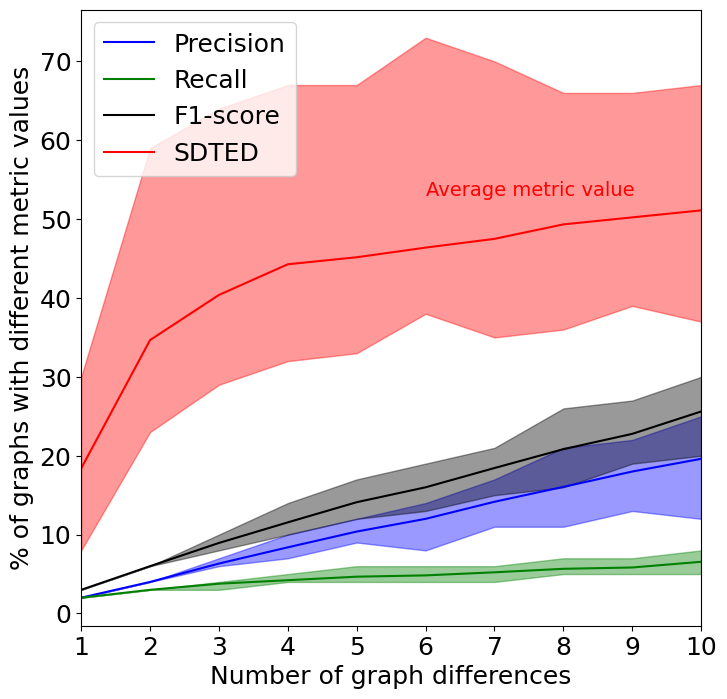

In [11]:
plt.style.use('default')
plt.figure(figsize=(8,8))

j_vals = sorted(dict_max_min['Max'].keys())
metrics = list(dict_max_min['Max'][j_vals[0]].keys())
factor_norm = NUM_GRAPHS*0.01

colors = ["blue", "green", "black", "red"]
for index, met in enumerate(metrics):
    plt.plot(j_vals,
             [dict_max_min['Mean'][j][met]/factor_norm  for j in j_vals],
             label=met,
             color=colors[index])

    plt.fill_between(j_vals, [dict_max_min['Max'][j][met]/factor_norm for j in j_vals], [dict_max_min['Min'][j][met]/factor_norm for j in j_vals], alpha=0.4, color=colors[index])
    
plt.text(6, 53, "Average metric value", fontsize=14, color="red")

plt.xticks(MUTATIONS_CALCULATE, fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(1,10)
plt.xlabel('Number of graph differences', fontsize=18)
plt.ylabel('% of graphs with different metric values', fontsize=18)
plt.legend(loc="upper left", fontsize=18)

plt.savefig(f"plots/area_cardinality_{NUM_GRAPHS}_norm.png")
plt.show()


# Case Studies

In [ ]:
name_graph = "kairos"
G = nx.read_gexf("graphs/graph_" + name_graph + ".gexf")
G_base = G.copy()

In [ ]:
H = G_base.copy()
F = G_base.copy()
F2 = G_base.copy()
H.remove_node('gtcache')
F.remove_node('profile')
F2.remove_node('mail')

write_SDTED_graphs([G_base, H, F, F2, nx.DiGraph()])
SDTED("SDTED/Data/CUSTOM")

df = pd.read_csv("Distance_Matrix.csv", nrows=1)

arr_SDTED = df.values.tolist()[0][1:]  # [0] gets the first (and only) row
arr_SDTED = [1 - min(x / arr_SDTED[-1], 1) for x in arr_SDTED][1:][:-1]

In [ ]:
print("Precision:", calc_precision(G_base, H))
print("Recall:", calc_recall(G_base, H))
print("F1-score:", calc_f1_score(G_base, H))
print("SDTED:", arr_SDTED[0])

print("Precision:", calc_precision(G_base, F))
print("Recall:", calc_recall(G_base, F))
print("F1-score:", calc_f1_score(G_base, F))
print("SDTED:", arr_SDTED[1])

print("Precision:", calc_precision(G_base, F2))
print("Recall:", calc_recall(G_base, F2))
print("F1-score:", calc_f1_score(G_base, F2))
print("SDTED:", arr_SDTED[2])

1.0
0.9545454545454546
0.9767441860465117
1.0
0.9545454545454546
0.9767441860465117
1.0
0.9545454545454546
0.9767441860465117


In [4]:
arr_mutations = [delete_random_node, delete_random_edge, change_direction_edge, add_random_node, add_random_edge]

MAX_GRAPH_DIFFERENCES = 20
# Number of copies of the original graph
NUM_GRAPHS = 100

## KAIROS GRAPH

In [5]:
name_graph = "kairos"
G = nx.read_gexf("graphs/graph_" + name_graph + ".gexf")
G_base = G.copy()

In [ ]:
arr_mut_metrics = []

MUTATIONS_CALCULATE = [1,5,10,15,20]

for num_mutations in MUTATIONS_CALCULATE:
    arr_g_candidate = []
    arr_precs = []
    arr_recalls = []
    arr_f1s = []

    arr_g_candidate.append(G_base)

    for graph in range(NUM_GRAPHS):
        G_candidate = G_base.copy()
        G_muted, log_mutations = mute_graph(G_candidate, arr_mutations, num_mutations)
        folder_path = "graphs/" + NAME_DS + '/' + str(num_mutations) + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        nx.write_gexf(G_muted, folder_path + 'G_' + str(graph + 1) + ".gexf")
        with open(folder_path + 'G_' + str(graph + 1) + ".log", 'w') as f: 
            for string in log_mutations:
                f.write(string + '\n') 
        arr_precs.append(calc_precision(G_base, G_muted))
        arr_recalls.append(calc_recall(G_base, G_muted))
        arr_f1s.append(calc_f1_score(G_base, G_muted))
        arr_g_candidate.append(G_muted)

    arr_g_candidate.append(nx.DiGraph())

    write_SDTED_graphs(arr_g_candidate)

    SDTED("SDTED/Data/CUSTOM")

    df = pd.read_csv("Distance_Matrix.csv", nrows=1)
    shutil.copy2("Distance_Matrix.csv", "graphs/" + NAME_DS + '/' + str(num_mutations) + '/' + 'distance_matrix_'+ str(NUM_GRAPHS) + '.csv')  

    arr_SDTED = df.values.tolist()[0][1:]  
    arr_SDTED = [1 - min(x / arr_SDTED[-1], 1) for x in arr_SDTED][1:][:-1]
    arr_metrics = [arr_precs, arr_recalls, arr_f1s, arr_SDTED]
    
    num_filas = max(len(arr) for arr in arr_metrics)

    trasp_metrics = []
    for i in range(num_filas):
        fila = [arr[i] if i < len(arr) else "" for arr in arr_metrics]
        trasp_metrics.append(fila)

    with open("graphs/" + NAME_DS + '/' + str(num_mutations) + '/metrics_' + str(NUM_GRAPHS) + '.csv' , "w", newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Precision", "Recall", "F1-score", "SDTED"])
        for array in trasp_metrics:
            writer.writerow(array)

    arr_mut_metrics.append(arr_metrics)


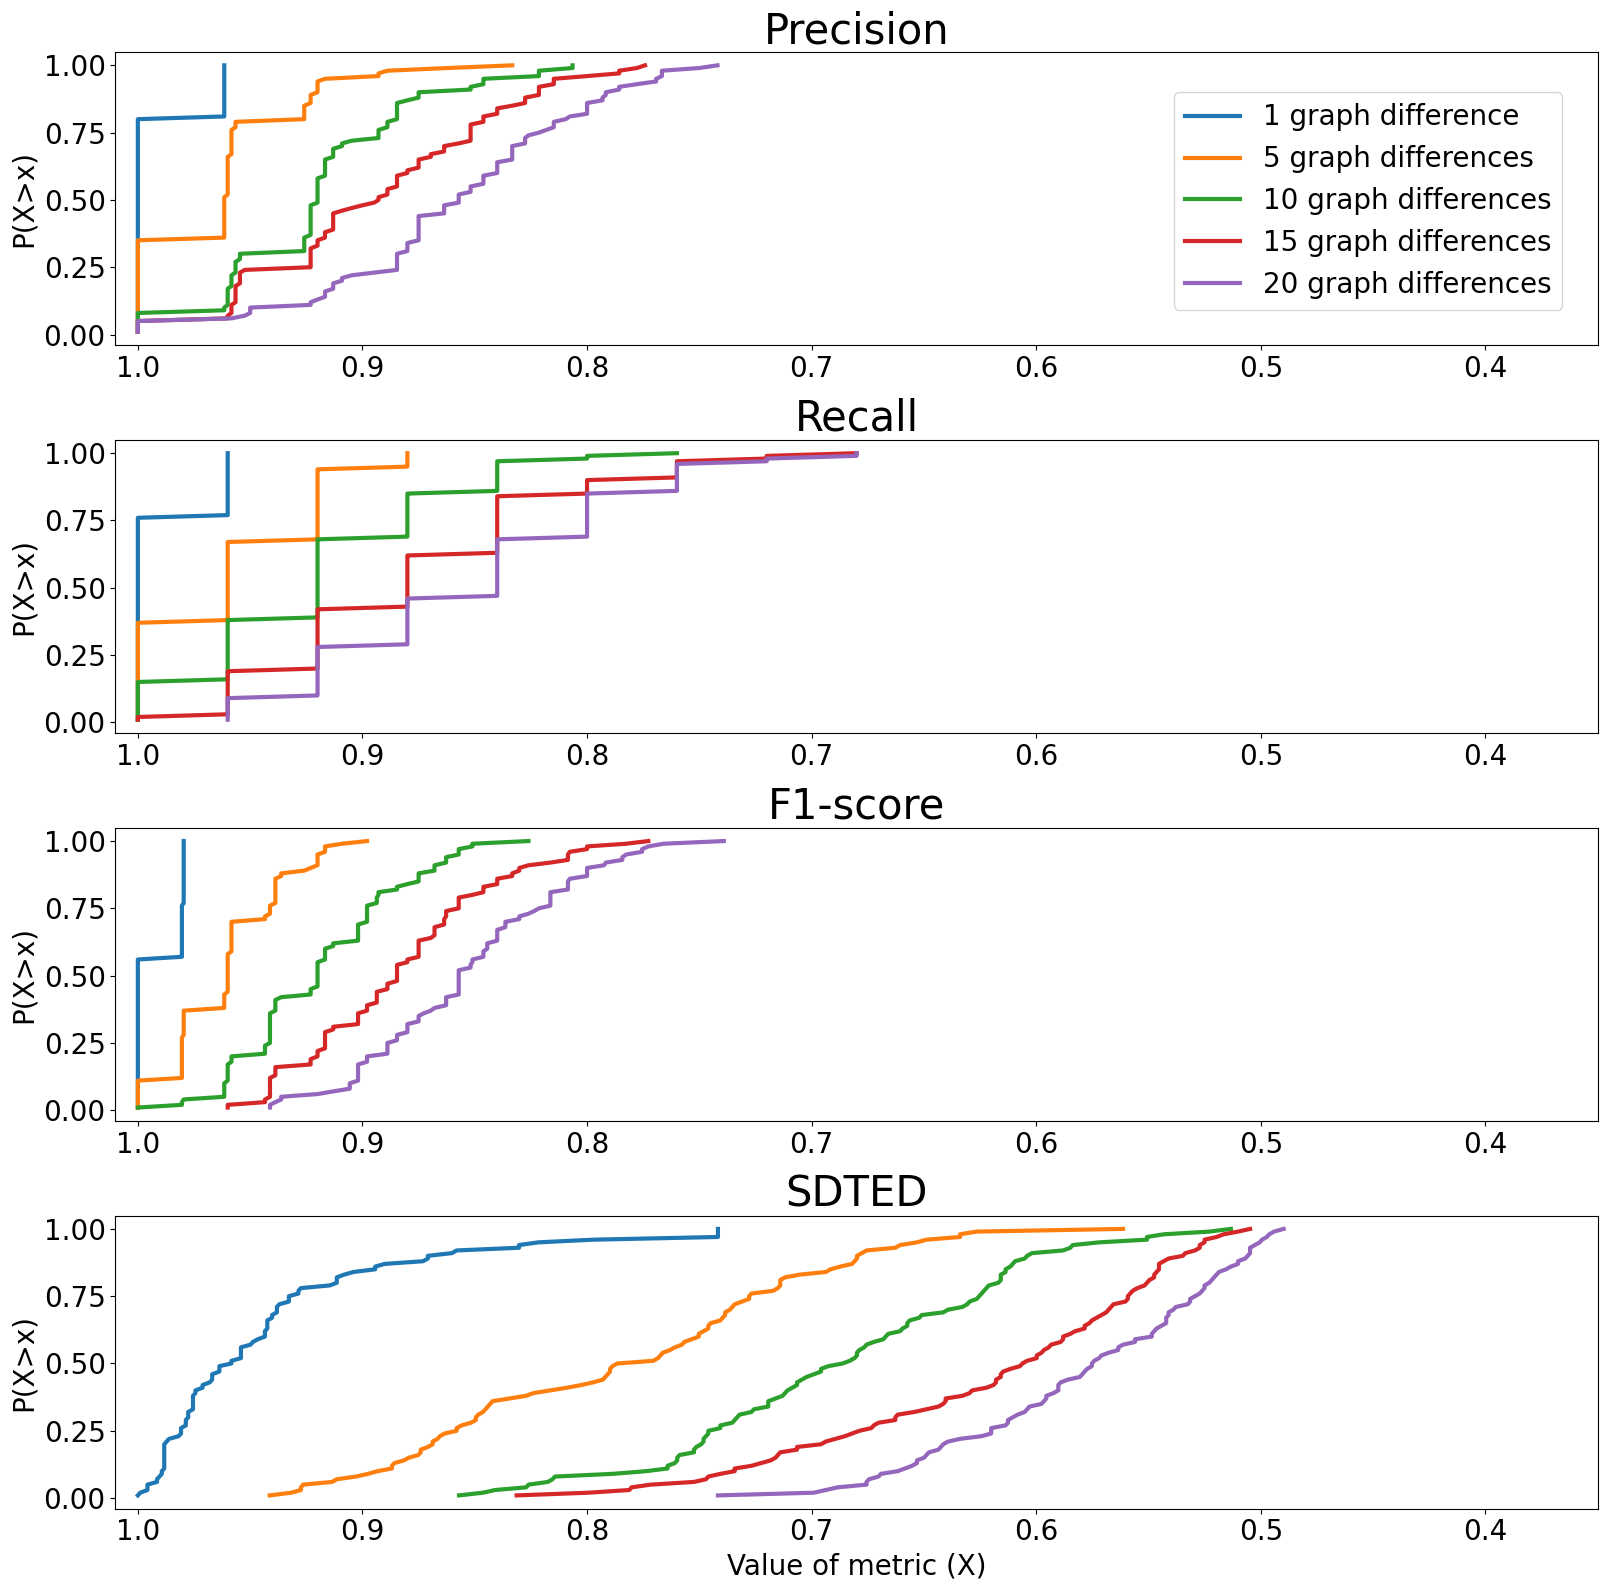

In [7]:
plt.style.use('default')
fig, axs = plt.subplots(4)
fig.set_size_inches(16, 16)

axs[0].set_title("Precision", fontsize=30)

axs[1].set_title("Recall", fontsize=30)

axs[2].set_title("F1-score", fontsize=30)

axs[3].set_title("SDTED", fontsize=30)
axs[3].set_xlabel("Value of metric (X)", fontsize=20)

for ax in axs:
    ax.set_ylabel("P(X>x)", fontsize=20)

for ax in axs:
    ax.invert_xaxis()
    ax.set_xlim(1.01, 0.35)
    ax.tick_params(labelsize=20)
        
for num_mutations, metrics_num_mut in enumerate(arr_mut_metrics):
    for index, metric in enumerate(metrics_num_mut):
        met_sorted = np.sort(metric)[::-1]
        cdf = np.arange(1, len(met_sorted) + 1) / len(met_sorted)
        if num_mutations == 0:
            axs[index].plot(met_sorted, cdf, label=f"1 graph difference" if index == 0 else "_nolegend_", alpha=1, linewidth=3)
        else:
            axs[index].plot(met_sorted, cdf, label=f"{num_mutations*5} graph differences" if index == 0 else "_nolegend_", alpha=1, linewidth=3)
        
fig.legend(loc=(0.73,0.805), prop={'size': 20})
fig.tight_layout()
plt.show()

fig.savefig("plots/" + name_graph + "_CDF_" + str(NUM_GRAPHS) + '_' + str(MAX_GRAPH_DIFFERENCES) + '.png')


## SLEUTH GRAPH

In [ ]:
name_graph = "SLEUTH"
G = nx.read_gexf("graphs/graph_" + name_graph + ".gexf")
G_base = G.copy()

In [ ]:
arr_mut_metrics = []

MUTATIONS_CALCULATE = [1,5,10,15,20]

for num_mutations in MUTATIONS_CALCULATE:
    arr_g_candidate = []
    arr_precs = []
    arr_recalls = []
    arr_f1s = []

    arr_g_candidate.append(G_base)
    for graph in range(NUM_GRAPHS):
        G_candidate = G_base.copy()
        G_muted, log_mutations = mute_graph(G_candidate, arr_mutations, num_mutations)
        folder_path = "graphs/" + NAME_DS + '/' + str(num_mutations) + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        nx.write_gexf(G_muted, folder_path + 'G_' + str(graph + 1) + ".gexf")
        with open(folder_path + 'G_' + str(graph + 1) + ".log", 'w') as f: 
            for string in log_mutations:
                f.write(string + '\n') 
        arr_precs.append(calc_precision(G_base, G_muted))
        arr_recalls.append(calc_recall(G_base, G_muted))
        arr_f1s.append(calc_f1_score(G_base, G_muted))
        arr_g_candidate.append(G_muted)

    arr_g_candidate.append(nx.DiGraph())

    write_SDTED_graphs(arr_g_candidate)
    SDTED("SDTED/Data/CUSTOM")

    df = pd.read_csv("Distance_Matrix.csv", nrows=1)
    shutil.copy2("Distance_Matrix.csv", "graphs/" + NAME_DS + '/' + str(num_mutations) + '/' + 'distance_matrix_'+ str(NUM_GRAPHS) + '.csv')  

    arr_SDTED = df.values.tolist()[0][1:]  # [0] gets the first (and only) row
    arr_SDTED = [1 - min(x / arr_SDTED[-1], 1) for x in arr_SDTED][1:][:-1]
    arr_metrics = [arr_precs, arr_recalls, arr_f1s, arr_SDTED]
    
    num_filas = max(len(arr) for arr in arr_metrics)

    trasp_metrics = []
    for i in range(num_filas):
        fila = [arr[i] if i < len(arr) else "" for arr in arr_metrics]
        trasp_metrics.append(fila)

    with open("graphs/" + NAME_DS + '/' + str(num_mutations) + '/metrics_' + str(NUM_GRAPHS) + '.csv' , "w", newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Precision", "Recall", "F1-score", "SDTED"])
        for array in trasp_metrics:
            writer.writerow(array)

    arr_mut_metrics.append(arr_metrics)


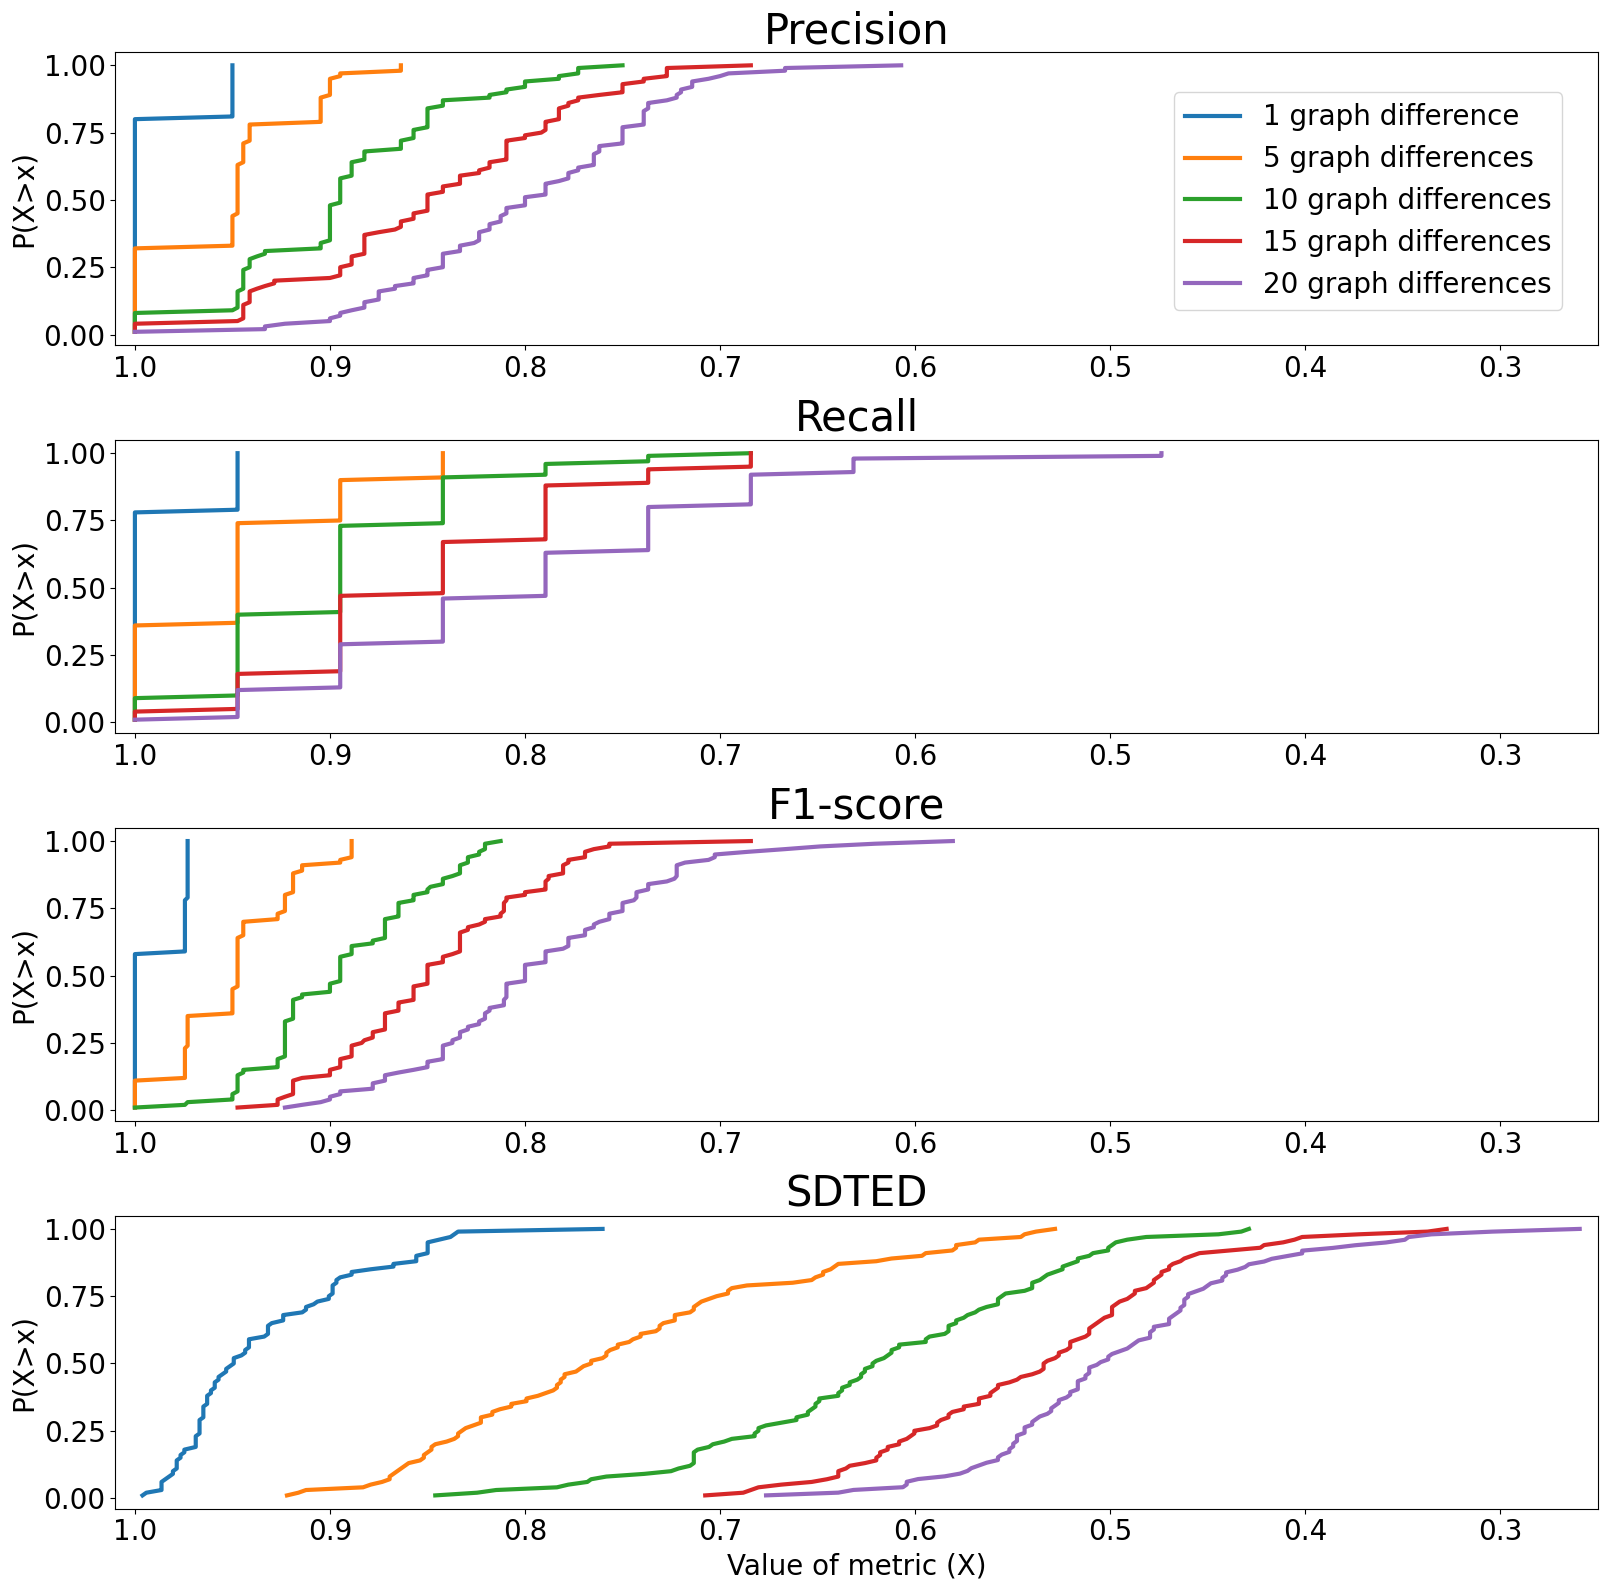

In [ ]:
plt.style.use('default')
fig, axs = plt.subplots(4)
fig.set_size_inches(16, 16)

axs[0].set_title("Precision", fontsize=30)

axs[1].set_title("Recall", fontsize=30)

axs[2].set_title("F1-score", fontsize=30)

axs[3].set_title("SDTED", fontsize=30)
axs[3].set_xlabel("Value of metric (X)", fontsize=20)

for ax in axs:
    ax.set_ylabel("P(X>x)", fontsize=20)

for ax in axs:
    ax.invert_xaxis()
    ax.set_xlim(1.01, 0.25)
    ax.tick_params(labelsize=20)
        
for num_mutations, metrics_num_mut in enumerate(arr_mut_metrics):
    for index, metric in enumerate(metrics_num_mut):
        met_sorted = np.sort(metric)[::-1]
        cdf = np.arange(1, len(met_sorted) + 1) / len(met_sorted)
        if num_mutations == 0:
            axs[index].plot(met_sorted, cdf, label=f"1 graph difference" if index == 0 else "_nolegend_", alpha=1, linewidth=3)
        else:
            axs[index].plot(met_sorted, cdf, label=f"{num_mutations*5} graph differences" if index == 0 else "_nolegend_", alpha=1, linewidth=3)
        
fig.legend(loc=(0.73,0.805), prop={'size': 20})
fig.tight_layout()
plt.show()

fig.savefig("plots/" + name_graph + "_CDF_" + str(NUM_GRAPHS) + '_' + str(MAX_GRAPH_DIFFERENCES) + '.png')

# Efficiency Analysis

In [ ]:
DICT_SHAPE_TYPE = {
    "ellipse": "file",
    "rectangle": "process",
    "diamond": "connection"
}

DICT_EDGE_TYPE = {
    "create": 0,
    "read": 1,
    "open": 2,
    "connect": 3,
    "send": 4, 
    "receive": 5,
    "write": 6,
    "execute": 7
}
    
DICT_NODE_TYPE = {
    "file": 0,
    "process": 1,
    "connection": 2
}


In [ ]:
arr_values = [200,400,600,800,1000,1200,1400,1600,1800,2000]
NUM_GRAPHS_EFF = 10

fact_posibles = {}

for num in arr_values:
    factorizaciones = factorize(num)
    fact_posibles[num] = []
    for nodes, edges in factorizaciones:
        if is_valid_graph(nodes, edges):
            fact_posibles[num].append([nodes, edges])

In [ ]:
# We randomly generate 10 graphs of each possible value sleecting edges and nodes
dict_graphs = {}
arr_tot_graphs = []
for num in arr_values:
    arr_graphs = []
    for i in range(NUM_GRAPHS_EFF):
        nodes, edges = random.choice(fact_posibles[num])
        arr_tot_graphs.append(gen_graph(nodes, edges))


In [ ]:
# We compute SDTED for all combinations
array_times = []

for index_i, g1 in enumerate(arr_tot_graphs):
    for index_j, g2 in enumerate(arr_tot_graphs):
        if index_i < index_j:
            multi_tuple = (g1.number_of_nodes()*g1.number_of_edges(), g2.number_of_nodes()*g2.number_of_edges())
            write_SDTED_graphs([g1, g2, nx.DiGraph()])
            res = subprocess.run(
                ["python3", "main.py", "Data/CUSTOM"],
                capture_output=True,
                text=False,
                cwd="SDTED/"
            )
            with open("time.txt", "r") as file:
                time = float(file.read())
            time_dim = (multi_tuple, time)
            array_times.append(time_dim)

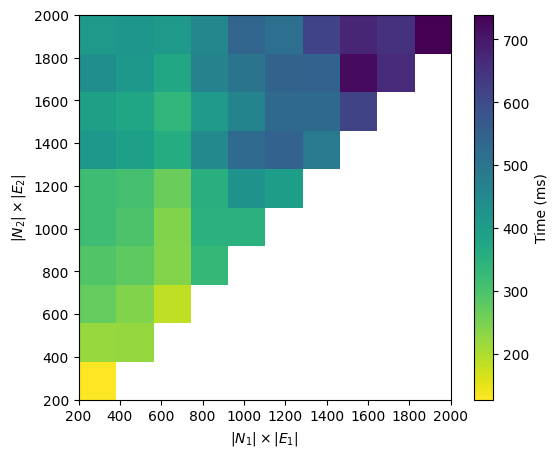

In [ ]:
value_dict = defaultdict(list)
for (x, y), value in array_times:
    key = (min(x, y), max(x, y))  
    value_dict[key].append(value)

average_values = {key: np.mean(vals) for key, vals in value_dict.items()}
x_vals = sorted(set(x for x, y in average_values.keys()))
y_vals = sorted(set(y for x, y in average_values.keys()))

heatmap = np.full((len(y_vals), len(x_vals)), np.nan) 
for (x, y), val in average_values.items():
    x_idx = x_vals.index(x)
    y_idx = y_vals.index(y)
    heatmap[y_idx, x_idx] = val

# Heatmap
plt.figure(figsize=(6, 5))
plt.imshow(heatmap, cmap='viridis_r', origin='lower', 
           extent=[min(x_vals), max(x_vals), min(y_vals), max(y_vals)], 
           aspect='auto')

plt.colorbar(label="Time (ms)")
plt.xticks(x_vals)
plt.yticks(y_vals)
plt.xlabel("$|N_1|\\times |E_1|$")
plt.ylabel("$|N_2|\\times |E_2|$")
plt.savefig("plots/heatmap_" + str(NUM_GRAPHS_EFF) + '_' + str(arr_values[0]) + '_' + str(arr_values[-1]) +".png")
plt.show()
